# The experiment with learning rate decay 

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

sys.path.append('../../..')

from batchflow import Pipeline, B, V, C
from batchflow.opensets import Imagenette160
from batchflow.models.torch import ResNet34
from batchflow.models.metrics import ClassificationMetrics
from batchflow.research import Research, Option, Results, KV, RP, REU, RI
from batchflow.utils import plot_results_by_config, show_research, print_results

Research parameters:

In [2]:
NUM_ITERS = 50000                               # number of iterations to train each model for
N_REPS = 7                                      # number of times to repeat each model train
RESEARCH_NAME = 'research'                      # name of Research object
DEVICES = [5, 6, 7]                             # devices to use
WORKERS = len(DEVICES)                          # number of simultaneously trained models
TEST_FREQUENCY = 150
BATCH_SIZE = 64

dataset = Imagenette160()                       # dataset to train models on
DS_TRAIN_LEN = len(dataset.train)

### Research domain

Learning rate schedules seek to adjust the learning rate during training by managing the learning rate according to a pre-defined schedule. Our domain consists of various learning rate decays and warmups. Let's check how useful they are! 

If you are not familiar with how to use decays in BatchFlow read it in [documentation](https://analysiscenter.github.io/batchflow/api/batchflow.models.torch.base.html).

In [3]:
domain = (Option('decay', [
    KV({'name': 'exp', 'gamma': .96, 'frequency': DS_TRAIN_LEN // BATCH_SIZE},
       'ordinary_1'),
    KV({'name': 'exp', 'gamma': .1, 'frequency': 7500},
       'ordinary_2'),
    KV([{'name': 'exp', 'gamma': 1.01, 'frequency': 6, 'last_iter': 900},
        {'name': 'exp', 'gamma': .9994, 'frequency': 2, 'first_iter': 901, 'last_iter': 22000}],
       'with_warmup_1'),
    KV([{'name': 'exp', 'gamma': 1, 'frequency': 1, 'last_iter': 900},
        {'name': 'exp', 'gamma': .9995, 'frequency': 2, 'first_iter': 901}],
       'with_warmup_2'),
    KV({'name': 'CyclicLR', 'base_lr': .0002, 'max_lr': .0016, 
        'step_size_up': 550, 'cycle_momentum': False, 
        'mode': 'exp_range', 'gamma': .99998, 'frequency': 1},
       'cyclic'),
    KV(None, 'None')
]))

Default config for our model:

In [4]:
config = {
    'inputs/labels/classes': 10,
    'head/layout': 'Vf',
    'head/units': 10,
    'decay': C('decay'),
    'device': C('device'),
}

### Train pipeline

Root and branch pipelines for the models training. We save loss and learning rate values for further comparison.

In [5]:
train_root = (dataset.train.p      
                  .crop(shape=(160, 160), origin='center')
                  .to_array(channels='first', dtype=np.float32)
                  .multiply(multiplier=1/255)
                  .run_later(BATCH_SIZE, n_epochs=None, drop_last=True,
                             shuffle=True)
                   )

train_pipeline = (Pipeline()
                  .init_variable('loss')
                  .init_variable('lr')
                  .init_model('dynamic', ResNet34, 'my_model', config=config) 
                  .train_model('my_model', B('images'), B('labels'), 
                               fetches=['loss', 'lr'], 
                               save_to=[V('loss'), V('lr')]
                              )
                 )

### Test pipeline and accuracy calculation

Function for accuracy computation on the test dataset. We will use it for decay comparison.

In [6]:
def acc(iteration, import_from):
    pipeline = (dataset.test.p
                 .import_model('my_model', import_from)
                 .init_variable('true', [])
                 .update(V('true', mode='a'), B.labels) 
                 .init_variable('predictions', [])
                 .crop(shape=(160, 160), origin='center')
                 .to_array(channels='first', dtype=np.float32)
                 .multiply(multiplier=1/255)
                 .predict_model('my_model', B('images'), fetches='predictions',
                                save_to=V('predictions', mode='a'))
                 )
    pipeline.run(128, n_epochs=1, drop_last=False, shuffle=True)
    pred = np.concatenate(pipeline.v('predictions'))
    true = np.concatenate(pipeline.v('true'))
    accuracy = ClassificationMetrics(true, pred, fmt='logits',
                                     num_classes=10, axis=1).accuracy()
    return accuracy

### Research

Research object that combines all of the foregoing and launches experiments in parallel. Results for all models will be collected in one file.

In [7]:
research = (Research()
            .init_domain(domain, n_reps=N_REPS)
            .add_pipeline(root=train_root, branch=train_pipeline, variables=['loss', 'lr'],
                          name='train_ppl', logging=True)
            .add_callable(acc, returns='acc_vall', name='acc_fn', execute=TEST_FREQUENCY,
                          iteration=RI(), import_from=RP('train_ppl')))

Start research!

In [ ]:
!rm -rf research

research.run(NUM_ITERS, name=RESEARCH_NAME,
             devices=DEVICES, workers=WORKERS,
             bar=True)

Research research is starting...


Domain updated: 0:   3%|▎         | 65512/2100000.0 [3:28:02<107:40:51,  5.25it/s]

### Results and conclusion

Load file with research results:

In [ ]:
%%time
results = Results(path=RESEARCH_NAME, concat_config=True)

Plots of the learning rate, loss, and accuracy on the test dataset.
The plots have curves for each model averaged over `N_REPS` executions.

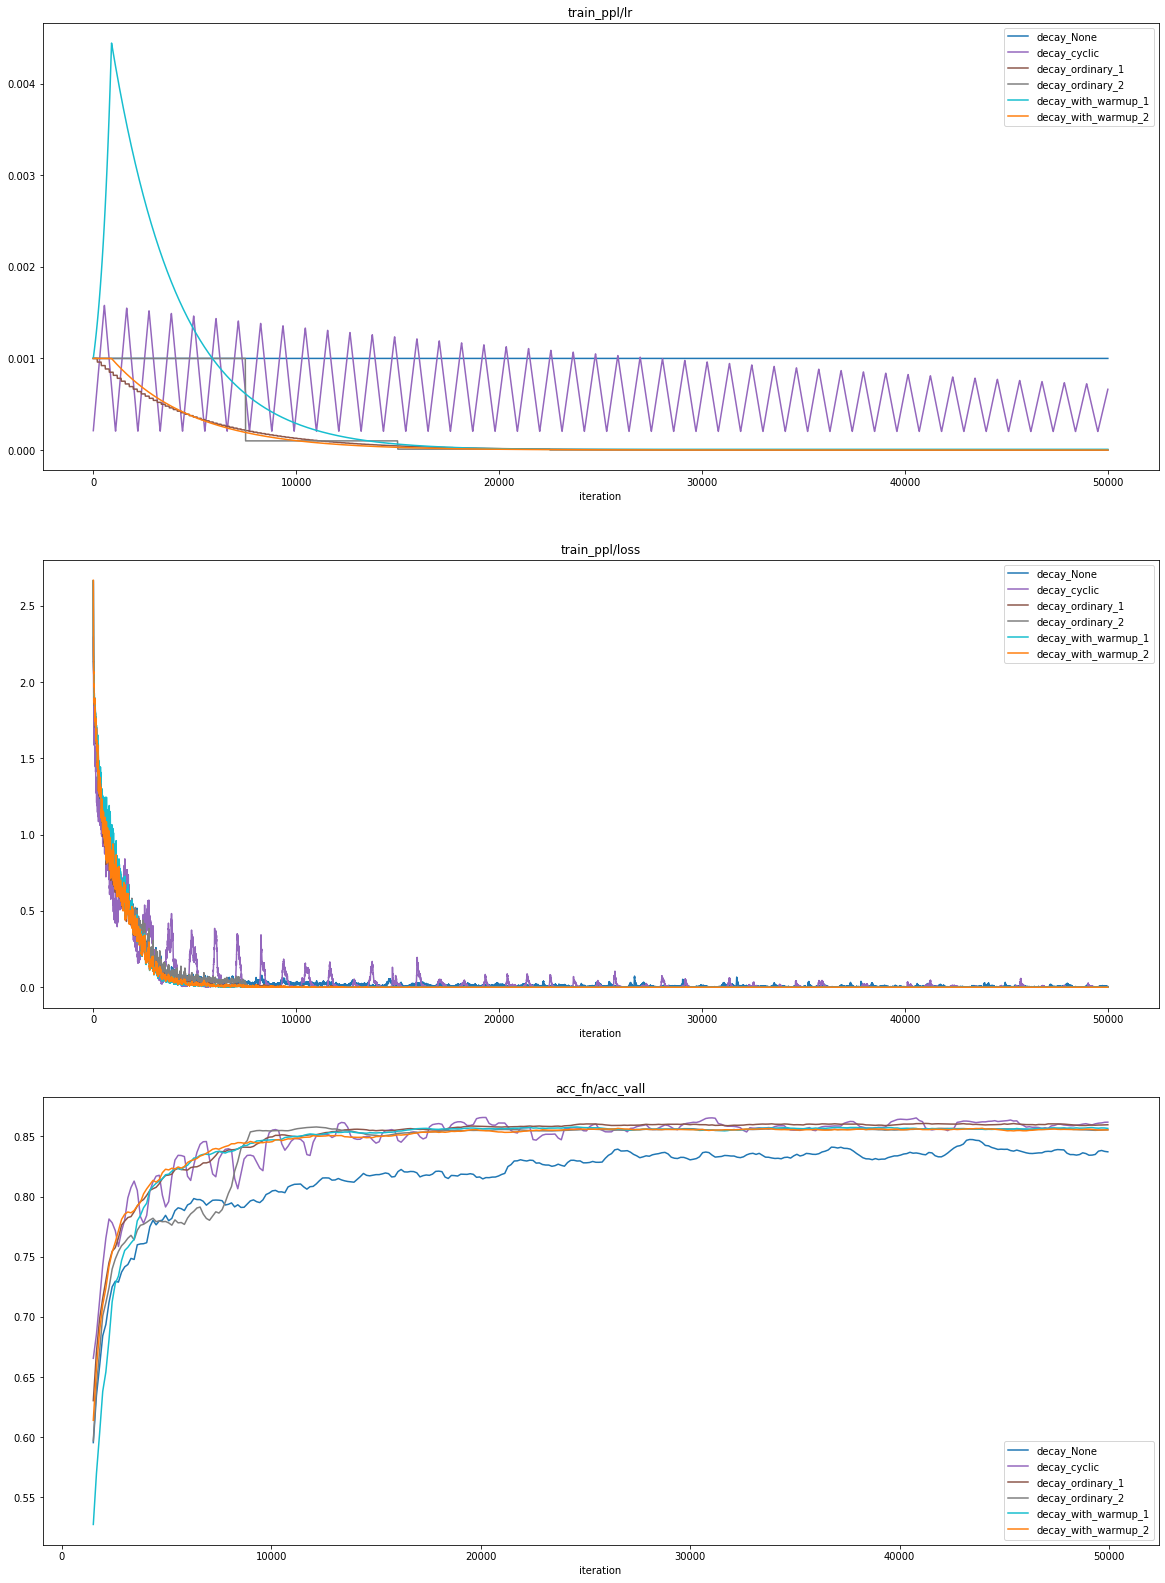

In [12]:
show_research(results.df, layout=['train_ppl/lr', 'train_ppl/loss', 'acc_fn/acc_vall'], average_repetitions=True, 
              color=list(mcolors.TABLEAU_COLORS.keys()), log_scale=False, rolling_window=10, 
              nrows=3, ncols=1, figsize=(20, 28))

Averaged test accuracy of last `n_last` measurements for each model for each execution.

In [13]:
print_results(results.df, 'acc_fn/acc_vall', False, ascending=True, n_last=100)

,acc_fn_5,acc_fn_0,acc_fn_3,acc_fn_6,acc_fn_2,acc_fn_1,acc_fn_4,acc_fn_mean,acc_fn_std
decay_None,0.815195,0.831622,0.848049,0.837782,0.831622,0.850103,0.848049,0.837489,0.011638
decay_cyclic,0.864476,0.866530,0.860370,0.868583,0.862423,0.870637,0.852156,0.863596,0.005688
decay_ordinary_1,0.860370,0.864476,0.850103,0.866530,0.862423,0.862423,0.856263,0.860370,0.005148
decay_ordinary_2,0.862423,0.852156,0.850103,0.862423,0.856263,0.856263,0.856263,0.856556,0.004311
decay_with_warmup_1,0.858316,0.852156,0.848049,0.856263,0.841889,0.856263,0.872690,0.855089,0.008907
decay_with_warmup_2,0.854209,0.839836,0.864476,0.856263,0.854209,0.862423,0.862423,0.856263,0.007761


From the results, it is obvious that a learning rate schedule should be used. And the most prospective learning rate schedules from that research: `'cyclic'` and `'ordinary_1'`. You can tune them and use them on your own projects. But besides that, current notebook can be your base notebook for testing other schedules for other tasks.